# Problem Statement:
The categorization of images into distinct classes is a pervasive task in computer vision, and it has a wide array of applications, including in pet identification and animal monitoring systems. In this assignment, we aim to develop a model
capable of accurately distinguishing between cat and dog images. Instead of building a convolutional neural network (CNN) from scratch, we will leverage transfer learning using the VGG16 model, a pre-trained model on the ImageNet dataset. VGG16 is renowned for its effectiveness in image recognition tasks, but it does not have broad categories for cats and dogs. Therefore, we will utilize the convolutional (Conv) layers of VGG16 for feature extraction and add custom fully connected (Cat) layers for the classification task.

# Objectives:

### Utilize VGG16 for Feature Extraction:

● Employ the VGG16 model, excluding its top layers, to serve as a feature extractor for cat and dog images.

● Ensure the input images are of the correct size (150x150) and preprocessed appropriately to match VGG16’s requirements.

### Data Preprocessing and Augmentation:

● Implement image data generators for real-time data augmentation, ensuring a robust and varied dataset for training the classification layers.

### Build and Train the Classification Model:

● Add custom fully connected layers on top of the VGG16 model for the classification task.

● Freeze the convolutional layers of VGG16 to retain the pre-trained features and only train the added classification layers.

### Model Compilation and Training:
● Compile the model using stochastic gradient descent, categorical cross-entropy as the loss function, and accuracy as the evaluation metric.

● Train the model using the training data, and validate its performance using a validation set.

### Evaluate and Test the Model:

● Assess the model’s performance based on its accuracy in classifying images into cat or dog categories.

● Implement a prediction function to classify new images, providing the predicted category and the associated confidence level

# 1. Load Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

C:\Users\raman\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# 2. Directory structure and parameters

In [2]:
def remove_corrupted_images(path):
    for filename in os.listdir(path):
        try:
            img = plt.imread(os.path.join(path, filename))
        except:
            os.remove(os.path.join(path, filename))

remove_corrupted_images("dataset/PetImages/Cat")
remove_corrupted_images("dataset/PetImages/Dog")

In [3]:
base_dir = r"C:\Users\raman\cats_dogs_dataset"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "validation")
test_dir  = os.path.join(base_dir, "test")

In [4]:
print("Base:", os.path.exists(base_dir))
print("Train:", os.path.exists(train_dir))
print("Validation:", os.path.exists(val_dir))
print("Test:", os.path.exists(test_dir))

print("Train folders:", os.listdir(train_dir))
print("Val folders:", os.listdir(val_dir))

Base: True
Train: True
Validation: True
Test: True
Train folders: ['cats', 'dogs']
Val folders: ['cats', 'dogs']


In [5]:
remove_corrupted_images(r"C:\Users\raman\cats_dogs_dataset\test\cats")
remove_corrupted_images(r"C:\Users\raman\cats_dogs_dataset\test\dogs")

remove_corrupted_images(r"C:\Users\raman\cats_dogs_dataset\train\cats")
remove_corrupted_images(r"C:\Users\raman\cats_dogs_dataset\train\dogs")

remove_corrupted_images(r"C:\Users\raman\cats_dogs_dataset\validation\cats")
remove_corrupted_images(r"C:\Users\raman\cats_dogs_dataset\validation\dogs")

# 3. Image Preprocessing & Data Augmentation

In [6]:
img_height = 150
img_width  = 150
batch_size = 32
num_classes = 2

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("Class indices:", train_generator.class_indices)

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Class indices: {'cats': 0, 'dogs': 1}


# 4. Load VGG16 as Feature Extractor

In [8]:
conv_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img_height, img_width, 3)
)


# Freeze VGG16 convolution layers
for layer in conv_base.layers:
    layer.trainable = False

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# 5. Build the Classification Model

In [9]:
model = keras.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 6. Compile the Model

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 7. Train the Model

In [11]:
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2524s 4s/step - accuracy: 0.8862 - loss: 0.8779 - val_accuracy: 0.9644 - val_loss: 0.1008
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2515s 4s/step - accuracy: 0.9125 - loss: 0.2103 - val_accuracy: 0.9604 - val_loss: 0.1006
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2505s 4s/step - accuracy: 0.9262 - loss: 0.1844 - val_accuracy: 0.9676 - val_loss: 0.0850
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2513s 4s/step - accuracy: 0.9252 - loss: 0.1874 - val_accuracy: 0.9712 - val_loss: 0.0797
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2500s 4s/step - accuracy: 0.9323 - loss: 0.1657 - val_accuracy: 0.9668 - val_loss: 0.1098
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2520s 4s/step - accuracy: 0.9341 - loss: 0.1635 - val_accuracy: 0.9676 - val_loss: 0.0882
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2526s 4s/step - accuracy: 0.9311 - loss: 0.1700 - val_accuracy: 0.9676 - val_loss: 0.0878
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2522s 4s/step - accuracy: 0.9282 - loss: 0.1802 - 

# 8. Evaluate

In [13]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 358s 5s/step - accuracy: 0.9680 - loss: 0.0914
Validation Accuracy: 96.80%


# 9. Plot training/validation curves

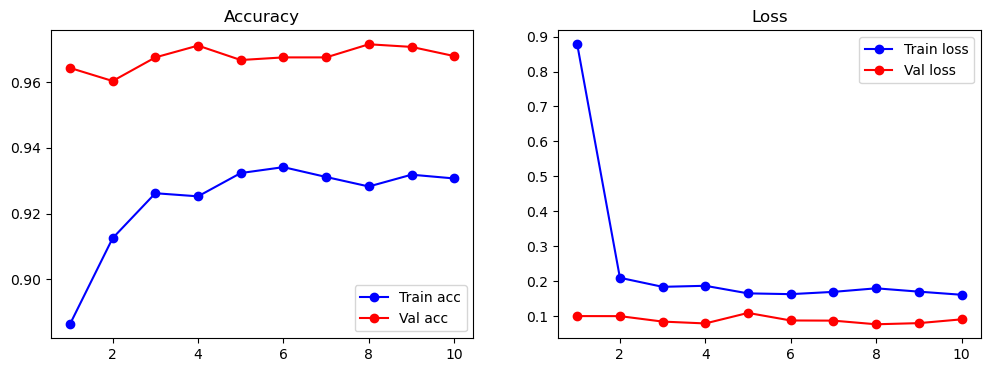

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, "bo-", label="Train acc")
plt.plot(epochs_range, val_acc, "ro-", label="Val acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, "bo-", label="Train loss")
plt.plot(epochs_range, val_loss, "ro-", label="Val loss")
plt.legend()
plt.title("Loss")

plt.show()

# 10. Prediction Function for New Images

In [15]:
from tensorflow.keras.preprocessing import image

class_indices = train_generator.class_indices
# invert dict: 0 -> 'cat', 1 -> 'dog'
idx_to_class = {v: k for k, v in class_indices.items()}

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    prob = np.max(preds)
    class_idx = np.argmax(preds)
    label = idx_to_class[class_idx]

    print(f"Predicted class: {label}")
    print(f"Confidence: {prob:.4f}")
    return label, float(prob)

In [16]:
image_path = r"C:\Users\raman\cats_dogs_dataset\test\dogs\2702.jpg"
print("Prediction:", predict_image(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Predicted class: dogs
Confidence: 1.0000
Prediction: ('dogs', 1.0)


In [17]:
image_path = r"C:\Users\raman\cats_dogs_dataset\test\cats\2423.jpg"
print("Prediction:", predict_image(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Predicted class: cats
Confidence: 0.9171
Prediction: ('cats', 0.9171438813209534)
